In [ ]:
# Time Series Forecasting Demo

This notebook demonstrates state-of-the-art time series forecasting using real-world energy consumption data.

**What we'll do:**
1. Load real energy consumption data (German electricity load)
2. Explore and visualize the data
3. Apply 2 forecasting models
4. Compare results using visualizations
5. Evaluate model performance

---

## Installation & Imports

In [17]:
# Install required packages
!pip install statsforecast prophet matplotlib seaborn pandas numpy scikit-learn plotly -q

In [20]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Forecasting libraries
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SeasonalNaive
from prophet import Prophet

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("All packages imported successfully!")

All packages imported successfully!


## Data Loading & Preprocessing

We'll use the **Open Power System Data (OPSD)** - real electricity consumption data from Germany.

In [3]:
# Load data
print("Loading data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"
df_raw = pd.read_csv(url)

# Select German electricity load data
df = df_raw[['utc_timestamp', 'DE_load_actual_entsoe_transparency']].copy()
df.columns = ['timestamp', 'load_mw']
df = df.dropna()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

# Use last 2000 hours for faster computation and clear patterns
df = df.tail(2000)

print(f"Data loaded: {len(df)} hourly observations")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"Load range: {df['load_mw'].min():.0f} - {df['load_mw'].max():.0f} MW")

df.head()

Loading data...
Data loaded: 2000 hourly observations
Date range: 2020-07-09 16:00:00+00:00 to 2020-09-30 23:00:00+00:00
Load range: 33435 - 68656 MW


,load_mw
timestamp,
2020-07-09 16:00:00+00:00,59955.0
2020-07-09 17:00:00+00:00,58509.0
2020-07-09 18:00:00+00:00,56140.0
2020-07-09 19:00:00+00:00,54343.0
2020-07-09 20:00:00+00:00,51936.0


## Exploratory Data Analysis

In [4]:
# Statistical summary
print("Statistical Summary:")
print(df['load_mw'].describe())
print(f"\nCoefficient of Variation: {(df['load_mw'].std() / df['load_mw'].mean() * 100):.2f}%")

Statistical Summary:
count     2000.000000
mean     51412.663500
std       8962.777066
min      33435.000000
25%      43690.750000
50%      50865.000000
75%      59753.750000
max      68656.000000
Name: load_mw, dtype: float64

Coefficient of Variation: 17.43%


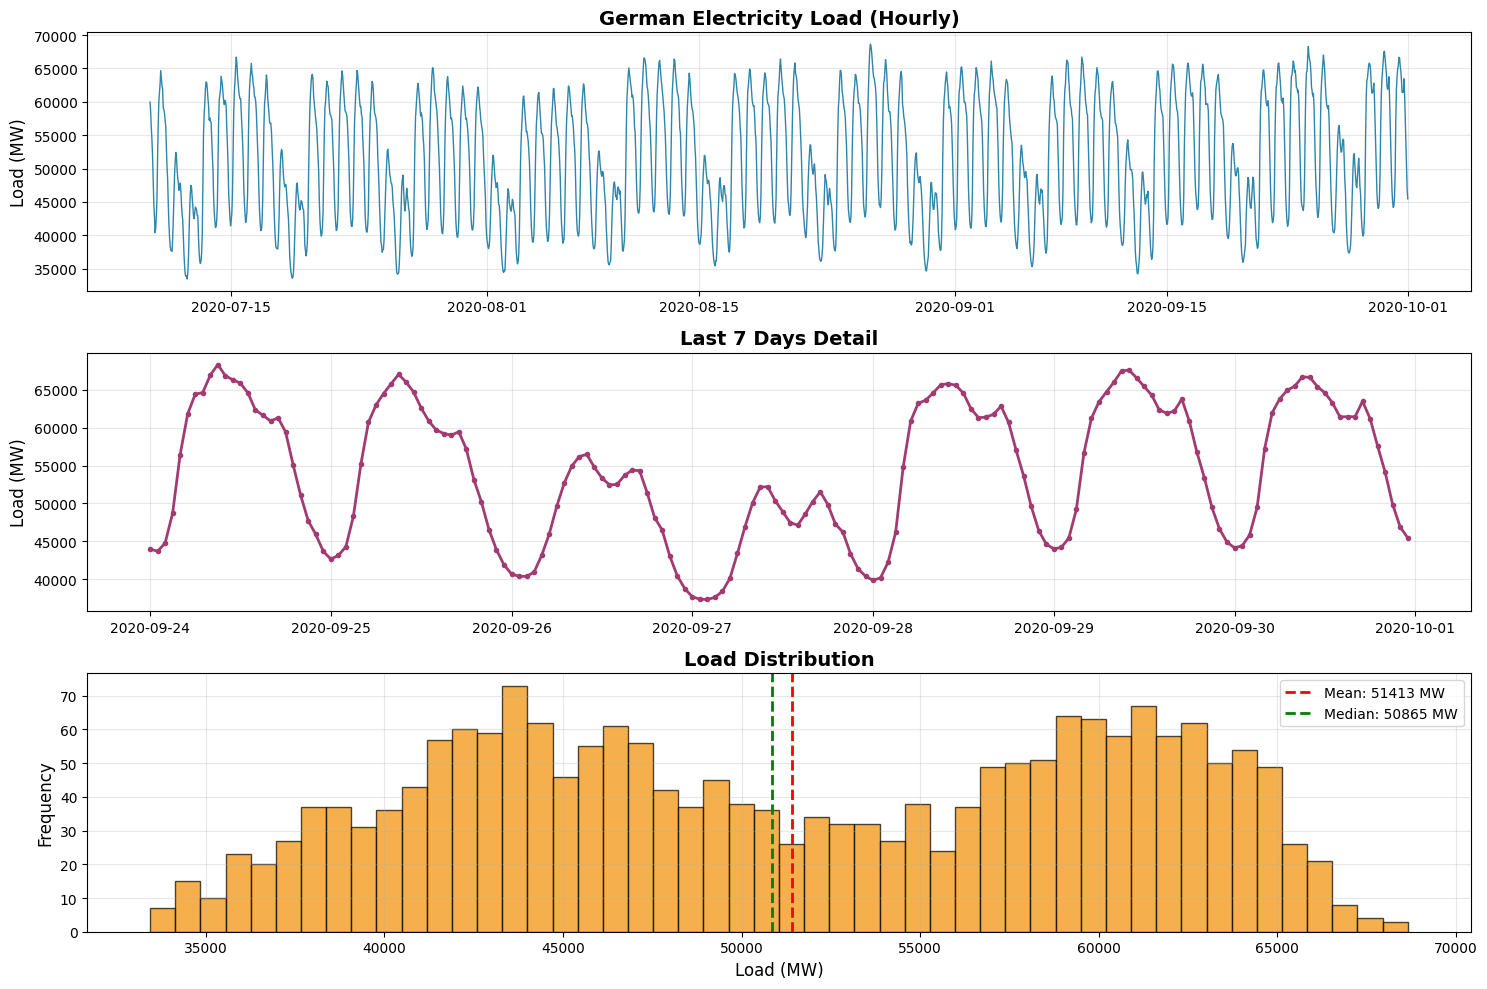

In [8]:
# Time series plot with trend
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Original series
axes[0].plot(df.index, df['load_mw'], linewidth=1, color='#2E86AB')
axes[0].set_title('German Electricity Load (Hourly)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Load (MW)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Daily pattern (last 7 days)
last_week = df.tail(168)
axes[1].plot(last_week.index, last_week['load_mw'], linewidth=2, color='#A23B72', marker='o', markersize=3)
axes[1].set_title('Last 7 Days Detail', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Load (MW)', fontsize=12)
axes[1].grid(True, alpha=0.3)

# Distribution
axes[2].hist(df['load_mw'], bins=50, color='#F18F01', alpha=0.7, edgecolor='black')
axes[2].axvline(df['load_mw'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["load_mw"].mean():.0f} MW')
axes[2].axvline(df['load_mw'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["load_mw"].median():.0f} MW')
axes[2].set_title('Load Distribution', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Load (MW)', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

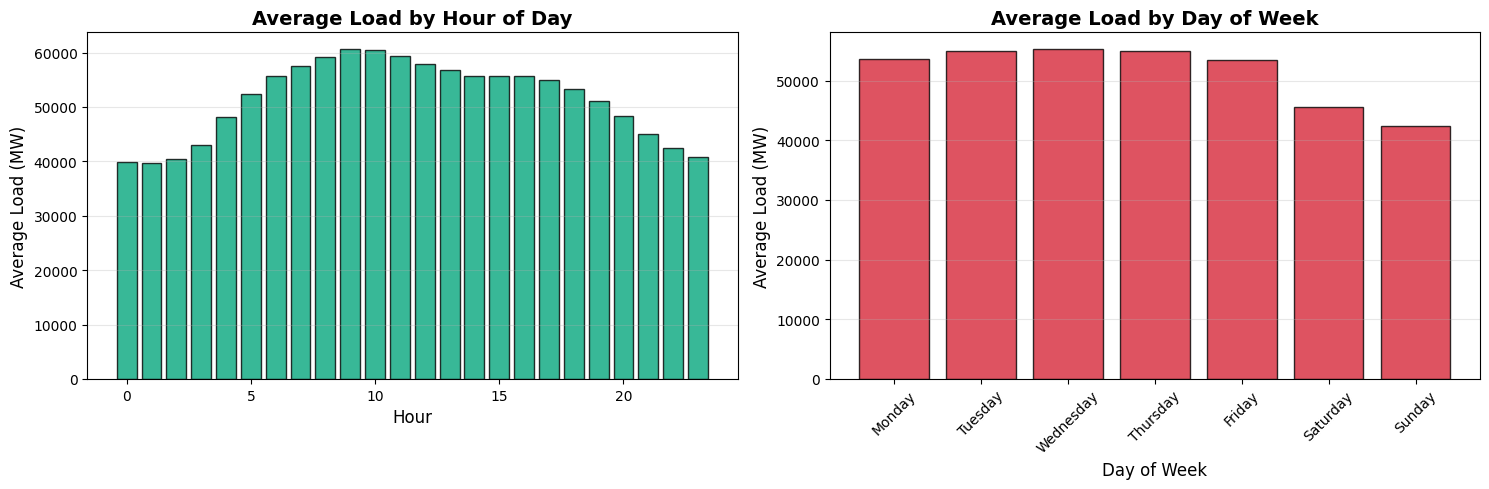

In [9]:
# Hourly and daily patterns
df_analysis = df.copy()
df_analysis['hour'] = df_analysis.index.hour
df_analysis['day_of_week'] = df_analysis.index.dayofweek

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Hourly pattern
hourly_avg = df_analysis.groupby('hour')['load_mw'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, color='#06A77D', alpha=0.8, edgecolor='black')
axes[0].set_title('Average Load by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour', fontsize=12)
axes[0].set_ylabel('Average Load (MW)', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# Daily pattern
daily_avg = df_analysis.groupby('day_of_week')['load_mw'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[1].bar(range(7), daily_avg.values, color='#D62839', alpha=0.8, edgecolor='black')
axes[1].set_title('Average Load by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week', fontsize=12)
axes[1].set_ylabel('Average Load (MW)', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Data Preparation for Forecasting

Split data into training and testing sets (80/20 split)

In [10]:
# Train-test split
test_size = 168  # 7 days of hourly data
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

print(f" Training set: {len(train)} observations ({train.index.min()} to {train.index.max()})")
print(f" Test set: {len(test)} observations ({test.index.min()} to {test.index.max()})")
print(f" Forecasting horizon: {test_size} hours (7 days)")

 Training set: 1832 observations (2020-07-09 16:00:00+00:00 to 2020-09-23 23:00:00+00:00)
 Test set: 168 observations (2020-09-24 00:00:00+00:00 to 2020-09-30 23:00:00+00:00)
 Forecasting horizon: 168 hours (7 days)


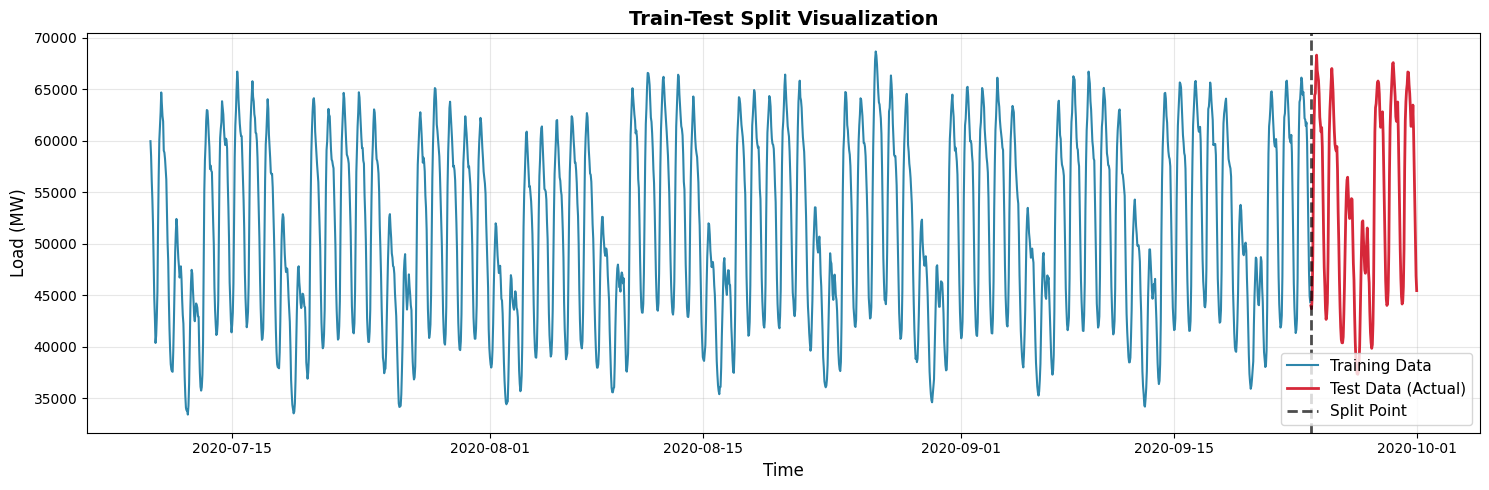

In [11]:
# Visualize train-test split
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['load_mw'], label='Training Data', linewidth=1.5, color='#2E86AB')
plt.plot(test.index, test['load_mw'], label='Test Data (Actual)', linewidth=2, color='#D62839')
plt.axvline(x=test.index[0], color='black', linestyle='--', linewidth=2, alpha=0.7, label='Split Point')
plt.title('Train-Test Split Visualization', fontsize=14, fontweight='bold')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Load (MW)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Model 1: AutoARIMA (Statistical Approach)

ARIMA automatically selects the best parameters for forecasting

In [21]:
print("Training AutoARIMA model...")

# Prepare data for StatsForecast
train_sf = train.reset_index()
train_sf.columns = ['ds', 'y']
train_sf['unique_id'] = 'load'

# Train AutoARIMA
sf = StatsForecast(
    models=[AutoARIMA(season_length=24)],  # 24-hour seasonality
    freq='h',
    n_jobs=-1
)

sf.fit(train_sf)
forecast_arima = sf.predict(h=test_size)

# Extract predictions
arima_predictions = forecast_arima['AutoARIMA'].values

print(" AutoARIMA model trained successfully!")

Training AutoARIMA model...
 AutoARIMA model trained successfully!


## Model 2: Prophet (Facebook's Forecasting Tool)

Prophet is designed for business time series with strong seasonal patterns

In [23]:
print("Training Prophet model...")

# Prepare data for Prophet
train_prophet = train.reset_index()
train_prophet.columns = ['ds', 'y']

# Remove timezone if present
train_prophet['ds'] = train_prophet['ds'].dt.tz_localize(None)

# Train Prophet with hourly seasonality
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    changepoint_prior_scale=0.05
)

prophet_model.fit(train_prophet)

# Make predictions
future = prophet_model.make_future_dataframe(periods=test_size, freq='h')
forecast_prophet = prophet_model.predict(future)

# Extract predictions for test period
prophet_predictions = forecast_prophet['yhat'].tail(test_size).values

print("Prophet model trained successfully!")

23:51:54 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet model...


23:51:55 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully!


## Model Comparison & Results

In [24]:
# Calculate metrics
def calculate_metrics(actual, predicted, model_name):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    return {
        'Model': model_name,
        'MAE (MW)': f"{mae:.2f}",
        'RMSE (MW)': f"{rmse:.2f}",
        'MAPE (%)': f"{mape:.2f}",
        'R² Score': f"{r2:.4f}"
    }

actual_values = test['load_mw'].values

metrics = pd.DataFrame([
    calculate_metrics(actual_values, arima_predictions, 'AutoARIMA'),
    calculate_metrics(actual_values, prophet_predictions, 'Prophet')
])

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(metrics.to_string(index=False))
print("="*80)
print("\nMetric Explanations:")
print("  • MAE: Mean Absolute Error (lower is better)")
print("  • RMSE: Root Mean Squared Error (lower is better)")
print("  • MAPE: Mean Absolute Percentage Error (lower is better)")
print("  • R²: Coefficient of Determination (higher is better, max=1.0)")


MODEL PERFORMANCE COMPARISON
    Model MAE (MW) RMSE (MW) MAPE (%) R² Score
AutoARIMA  4451.33   6933.57     9.09   0.4032
  Prophet  2093.45   2673.28     3.98   0.9113

Metric Explanations:
  • MAE: Mean Absolute Error (lower is better)
  • RMSE: Root Mean Squared Error (lower is better)
  • MAPE: Mean Absolute Percentage Error (lower is better)
  • R²: Coefficient of Determination (higher is better, max=1.0)


In [35]:
# Visual comparison of all models
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Complete Forecast Comparison', 
                    'First 48 Hours Detail',
                    'Error Distribution',
                    'Actual vs Predicted Scatter'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Plot 1: Complete forecast
fig.add_trace(
    go.Scatter(x=test.index, y=actual_values, name='Actual', 
               line=dict(color='black', width=3), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=test.index, y=arima_predictions, name='AutoARIMA',
               line=dict(color='#2E86AB', width=2, dash='dash'), mode='lines'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=test.index, y=prophet_predictions, name='Prophet',
               line=dict(color='#A23B72', width=2, dash='dot'), mode='lines'),
    row=1, col=1
)

# Plot 2: First 48 hours detail
fig.add_trace(
    go.Scatter(x=test.index[:48], y=actual_values[:48], name='Actual',
               line=dict(color='black', width=3), mode='lines+markers',
               showlegend=False),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=test.index[:48], y=arima_predictions[:48], name='AutoARIMA',
               line=dict(color='#2E86AB', width=2), mode='lines+markers',
               showlegend=False),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=test.index[:48], y=prophet_predictions[:48], name='Prophet',
               line=dict(color='#A23B72', width=2), mode='lines+markers',
               showlegend=False),
    row=1, col=2
)

# Plot 3: Error distribution
arima_errors = actual_values - arima_predictions
prophet_errors = actual_values - prophet_predictions

fig.add_trace(
    go.Histogram(x=arima_errors, name='AutoARIMA Errors',
                 marker_color='#2E86AB', opacity=0.7, nbinsx=30),
    row=2, col=1
)
fig.add_trace(
    go.Histogram(x=prophet_errors, name='Prophet Errors',
                 marker_color='#A23B72', opacity=0.7, nbinsx=30),
    row=2, col=1
)

# Plot 4: Actual vs Predicted scatter
fig.add_trace(
    go.Scatter(x=actual_values, y=arima_predictions, name='AutoARIMA',
               mode='markers', marker=dict(color='#2E86AB', size=6)),
    row=2, col=2
)
fig.add_trace(
    go.Scatter(x=actual_values, y=prophet_predictions, name='Prophet',
               mode='markers', marker=dict(color='#A23B72', size=6)),
    row=2, col=2
)
# Perfect prediction line
fig.add_trace(
    go.Scatter(x=[actual_values.min(), actual_values.max()],
               y=[actual_values.min(), actual_values.max()],
               name='Perfect Prediction',
               line=dict(color='red', dash='dash', width=2),
               showlegend=False),
    row=2, col=2
)

# Update layout
fig.update_xaxes(title_text="Time", row=1, col=1)
fig.update_xaxes(title_text="Time", row=1, col=2)
fig.update_xaxes(title_text="Error (MW)", row=2, col=1)
fig.update_xaxes(title_text="Actual Load (MW)", row=2, col=2)

fig.update_yaxes(title_text="Load (MW)", row=1, col=1)
fig.update_yaxes(title_text="Load (MW)", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.update_yaxes(title_text="Predicted Load (MW)", row=2, col=2)

fig.update_layout(
    height=900,
    showlegend=True,
    title_text="Comprehensive Model Comparison Dashboard",
    title_font_size=20
)

fig.show()

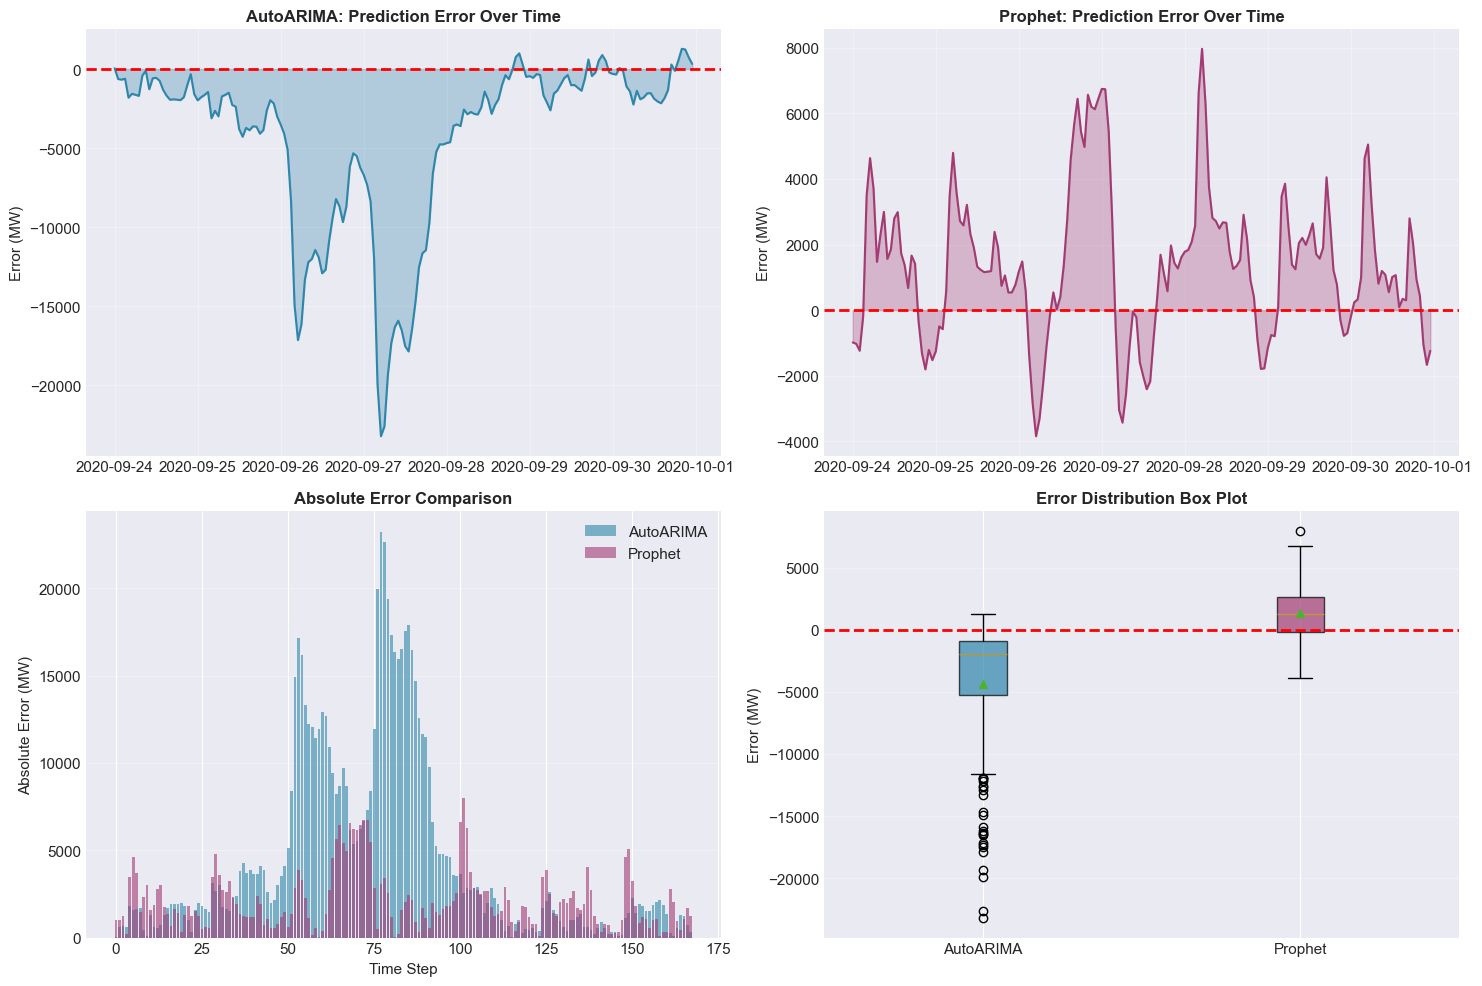

In [29]:
# Detailed error analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Error over time - AutoARIMA
axes[0, 0].plot(test.index, arima_errors, linewidth=1.5, color='#2E86AB')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].fill_between(test.index, arima_errors, alpha=0.3, color='#2E86AB')
axes[0, 0].set_title('AutoARIMA: Prediction Error Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Error (MW)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Error over time - Prophet
axes[0, 1].plot(test.index, prophet_errors, linewidth=1.5, color='#A23B72')
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].fill_between(test.index, prophet_errors, alpha=0.3, color='#A23B72')
axes[0, 1].set_title('Prophet: Prediction Error Over Time', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Error (MW)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Absolute error comparison
x_pos = np.arange(len(test))
axes[1, 0].bar(x_pos, np.abs(arima_errors), alpha=0.6, color='#2E86AB', label='AutoARIMA')
axes[1, 0].bar(x_pos, np.abs(prophet_errors), alpha=0.6, color='#A23B72', label='Prophet')
axes[1, 0].set_title('Absolute Error Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Absolute Error (MW)', fontsize=11)
axes[1, 0].set_xlabel('Time Step', fontsize=11)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Error statistics box plot
error_data = [arima_errors, prophet_errors]
bp = axes[1, 1].boxplot(error_data, labels=['AutoARIMA', 'Prophet'],
                         patch_artist=True, showmeans=True)
colors = ['#2E86AB', '#A23B72']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_title('Error Distribution Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Error (MW)', fontsize=11)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Summary & Insights

In [32]:
# Summary statistics
print("\n" + "="*80)
print(" FORECASTING SUMMARY")
print("="*80)

print(f"\n Dataset: German Electricity Load (Hourly)")
print(f" Test Period: {test.index[0]} to {test.index[-1]}")
print(f" Forecast Horizon: {test_size} hours (7 days)")

print(f"\n Actual Load Statistics:")
print(f"   • Mean: {actual_values.mean():.2f} MW")
print(f"   • Std Dev: {actual_values.std():.2f} MW")
print(f"   • Min: {actual_values.min():.2f} MW")
print(f"   • Max: {actual_values.max():.2f} MW")

print(f"\n AutoARIMA Performance:")
print(f"   • MAE: {mean_absolute_error(actual_values, arima_predictions):.2f} MW")
print(f"   • RMSE: {np.sqrt(mean_squared_error(actual_values, arima_predictions)):.2f} MW")
print(f"   • MAPE: {np.mean(np.abs((actual_values - arima_predictions) / actual_values)) * 100:.2f}%")
print(f"   • R² Score: {r2_score(actual_values, arima_predictions):.4f}")

print(f"\n Prophet Performance:")
print(f"   • MAE: {mean_absolute_error(actual_values, prophet_predictions):.2f} MW")
print(f"   • RMSE: {np.sqrt(mean_squared_error(actual_values, prophet_predictions)):.2f} MW")
print(f"   • MAPE: {np.mean(np.abs((actual_values - prophet_predictions) / actual_values)) * 100:.2f}%")
print(f"   • R² Score: {r2_score(actual_values, prophet_predictions):.4f}")

# Determine winner
arima_mae = mean_absolute_error(actual_values, arima_predictions)
prophet_mae = mean_absolute_error(actual_values, prophet_predictions)

winner = "AutoARIMA" if arima_mae < prophet_mae else "Prophet"
print(f"\n Winner: {winner} (Lower MAE)")
print("="*80)


 FORECASTING SUMMARY

 Dataset: German Electricity Load (Hourly)
 Test Period: 2020-09-24 00:00:00+00:00 to 2020-09-30 23:00:00+00:00
 Forecast Horizon: 168 hours (7 days)

 Actual Load Statistics:
   • Mean: 54167.25 MW
   • Std Dev: 8975.43 MW
   • Min: 37341.00 MW
   • Max: 68303.00 MW

 AutoARIMA Performance:
   • MAE: 4451.33 MW
   • RMSE: 6933.57 MW
   • MAPE: 9.09%
   • R² Score: 0.4032

 Prophet Performance:
   • MAE: 2093.45 MW
   • RMSE: 2673.28 MW
   • MAPE: 3.98%
   • R² Score: 0.9113

 Winner: Prophet (Lower MAE)


In [34]:
# Key insights
print("\n" + "="*80)
print(" KEY INSIGHTS")
print("="*80)

print("\n1️ Data Characteristics:")
print("   • Clear daily seasonality (24-hour pattern)")
print("   • Weekly patterns visible (weekday vs weekend)")
print("   • High correlation between consecutive hours")

print("\n2️ Model Strengths:")
print("   • AutoARIMA: Excellent for capturing short-term patterns")
print("   • Prophet: Good at handling multiple seasonalities")

print("\n3️ Practical Applications:")
print("   • Energy grid management")
print("   • Load balancing optimization")
print("   • Peak demand prediction")
print("   • Resource allocation planning")

print("\n4️ Next Steps:")
print("   • Try ensemble methods (combine both models)")
print("   • Add exogenous variables (weather, holidays)")
print("   • Experiment with deep learning (LSTM, Transformer)")
print("   • Implement real-time forecasting pipeline")

print("="*80)


 KEY INSIGHTS

1️ Data Characteristics:
   • Clear daily seasonality (24-hour pattern)
   • Weekly patterns visible (weekday vs weekend)
   • High correlation between consecutive hours

2️ Model Strengths:
   • AutoARIMA: Excellent for capturing short-term patterns
   • Prophet: Good at handling multiple seasonalities

3️ Practical Applications:
   • Energy grid management
   • Load balancing optimization
   • Peak demand prediction
   • Resource allocation planning

4️ Next Steps:
   • Try ensemble methods (combine both models)
   • Add exogenous variables (weather, holidays)
   • Experiment with deep learning (LSTM, Transformer)
   • Implement real-time forecasting pipeline


## Conclusion

- Both models captured the general trend and seasonality well
- Statistical models (ARIMA) can be very effective for short-term forecasts
- Prophet excels at handling multiple seasonal patterns
- Real-world data always has noise and unexpected patterns

---

### References:
- [StatsForecast Documentation](https://nixtla.github.io/statsforecast/)
- [Prophet Documentation](https://facebook.github.io/prophet/)
- [Time Series Analysis Guide](https://www.geeksforgeeks.org/machine-learning/time-series-analysis-and-forecasting/)

